# Plot scan

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from auxPlots import readContours,label_line
import seaborn as sns
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load Recast Data

In [2]:
files = {'ATLAS-SUSY-2018-13' :'../pp2BB1j_2018_13_new.pcl',
         'ATLAS-SUSY-2016-08' :'../pp2BB1j_2016_08_new.pcl',
         'CMS-EXO-20-004' :'../pp2BB1j_cms.pcl',}

recastDataDict = {label : pd.read_pickle(f) for label,f in files.items()}

In [3]:
r = recastDataDict['ATLAS-SUSY-2016-08']
r = r[r['mLLP'] == 530.]
r.T

,42
Luminosity (1/fb),32.8
$N_s$,0.4316
$N_s$ Err,0.2079
AccEff,0.000046
AccEffErr,0.000022
Total,"(9371.0, 1.0)"
Total Error,"(50.43, 0.0)"
Jet+MET selection,"(751.6, 0.0802)"
Jet+MET selection Error,"(14.28, 0.001524)"
DV selection,"(0.4316, 4.605e-05)"


### Get all model points

In [4]:
msb = 'mLLP'
mn1= 'mLSP'
tau = 'tau_ns'
models = []
mCols = [msb,mn1,tau]
for recastData in recastDataDict.values():
    recastData.sort_values(mCols,inplace=True)
    for row in recastData[mCols].values:
        m = dict(zip(mCols,row.tolist()))
        if m not in models:
            models.append(m)
print('%i models loaded' %len(models))

58 models loaded


### Get Model parameters

In [5]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in [msb,mn1,tau]])
print(textstr)

{'mLLP': [1410.0, 515.0, 1030.0, 520.0, 907.0, 525.0, 910.0, 530.0, 915.0, 407.0, 410.0, 1307.0, 925.0, 415.0, 1315.0, 420.0, 1320.0, 425.0, 810.0, 1707.0, 815.0, 307.0, 820.0, 310.0, 1207.0, 1210.0, 315.0, 830.0, 1215.0, 707.0, 325.0, 710.0, 715.0, 207.0, 210.0, 1107.0, 725.0, 1110.0, 215.0, 1115.0, 220.0, 733.0, 607.0, 610.0, 1507.0, 1125.0, 615.0, 1512.0, 107.0, 620.0, 110.0, 1007.0, 625.0, 1010.0, 1015.0, 507.0, 1020.0, 510.0], 'mLSP': [800.0, 900.0, 1400.0, 1700.0, 100.0, 200.0, 1000.0, 300.0, 1100.0, 400.0, 1200.0, 500.0, 1300.0, 600.0, 1500.0, 700.0], 'tau_ns': [0.8800000534791889, 1.2999999802491649, 0.3500000797630081, 0.8400000306289893, 0.36000006563355796, 0.7899999591917372, 0.34000006198724925, 0.7199999737465825, 0.3099999717411147, 0.29000002202977987, 1.1999999999999997, 0.75, 0.047999999999999994, 0.2800000340322132, 0.0989999977438469, 0.09999999999999999, 0.09599999999999999, 0.03900000711030212, 0.36999998313582577, 0.04, 0.5600000680644264, 0.12999999802491646, 0.

### Plot exclusion for each analysis

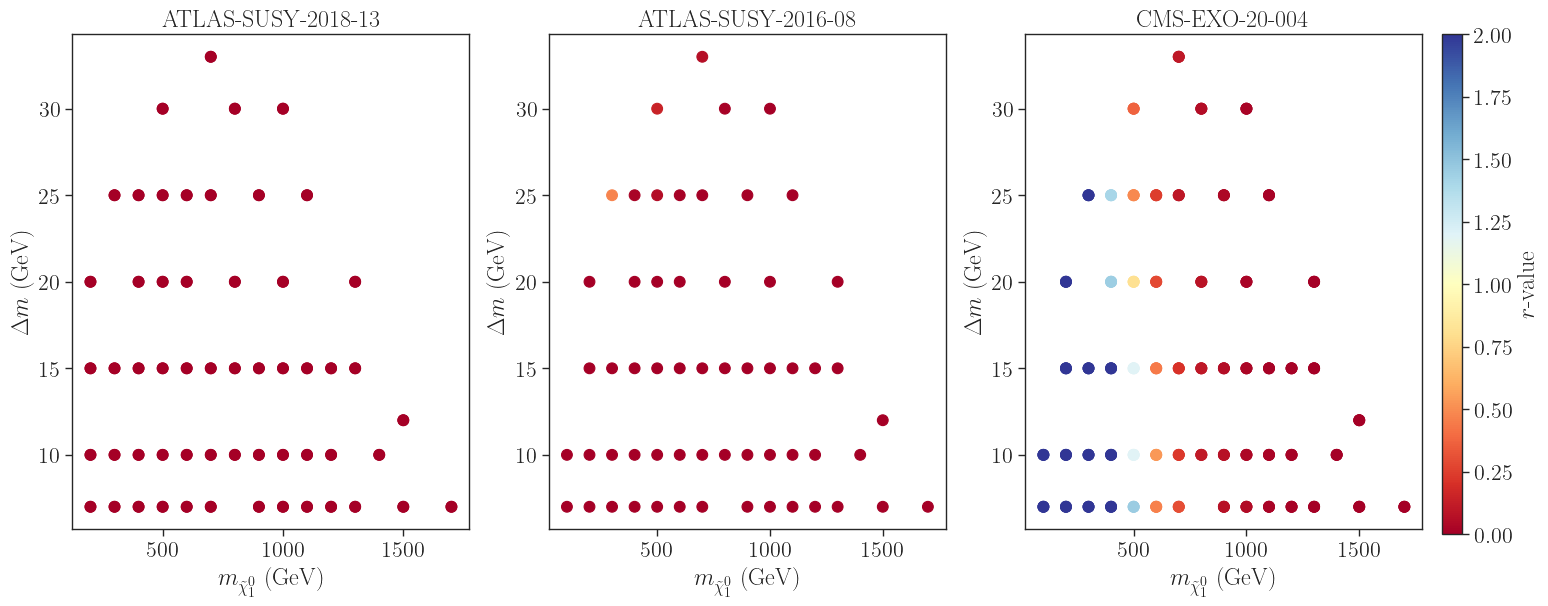

In [6]:
fig,axarr = plt.subplots(nrows=1,ncols=len(recastDataDict),figsize=(20,5))

for iplot,label in enumerate(recastDataDict):
    ax = axarr[iplot]
    recastData = recastDataDict[label]
    y = recastData[msb]-recastData[mn1]
    x = recastData[mn1]
    rValues = recastData['robs']
    p = ax.scatter(x=x,y=y,vmin=0.0,vmax=2.0,
            c=rValues,cmap=cm,s=60)
    
    ax.set_xlabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
    ax.set_ylabel(r'$\Delta m$ (GeV)')
    ax.set_title('%s' %label)

fig.subplots_adjust(right=0.8,top=1.1)
cbar_ax = fig.add_axes([0.81, 0.1, 0.01, 1.0])
# fig.colorbar(r, cax=cbar_ax)    
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)
# plt.tight_layout()
plt.show()